In [1]:
# !pip3 install wordcloud

In [2]:
import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

import gensim
from gensim import corpora
from gensim import similarities
from gensim import models

from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import os

## EDA

### EDA at words level

In [3]:
file_directory = '/Users/wyf/Downloads/is450/text-mining-project/text'

filename_pattern = '.+\.txt'

corpus = PlaintextCorpusReader(file_directory, filename_pattern, encoding='latin-1')
fids = corpus.fileids()
print(fids)
print("Number of documents in the collection: ", len(fids))

docs_len = [len(corpus.words(f)) for f in fids]
print("Number of words in each of the books: ", docs_len)

['11.txt', '12406.txt', '13493.txt', '13791.txt', '13888.txt', '14328.txt', '146.txt', '1497.txt', '15489.txt', '16.txt', '16331.txt', '16965.txt', '1727.txt', '17388.txt', '19031.txt', '20203.txt', '20763.txt', '2130.txt', '22114.txt', '23319.txt', '23609.txt', '23680.txt', '24518.txt', '24708.txt', '24964.txt', '31529.txt', '31630.txt', '31671.txt', '34901.txt', '35534.txt', '3800.txt', '4339.txt', '4363.txt', '514.txt', '6763.txt', '6934.txt', '7370.txt', '7524.txt', '852.txt', '8crmp10.txt', '926.txt', 'bygdv10.txt', 'dmedu10.txt', 'ethic10.txt', 'lprss11.txt', 'lwmen10.txt', 'nkrnn09.txt', 'nrvcs10.txt', 'pandp10.txt', 'peter16.txt', 'poeti10.txt', 'repub11.txt', 'thrdm10.txt', 'trgov10.txt', 'utopi10.txt', 'wltnt10.txt']
Number of documents in the collection:  56
Number of words in each of the books:  [37857, 24226, 57710, 18649, 85846, 54981, 84905, 251925, 64611, 62472, 159082, 44158, 152936, 97380, 59749, 96298, 53369, 53010, 42857, 90554, 168191, 19514, 332516, 37222, 22781, 

In [4]:
# number of unique words for each of the books (before data pre-processing)
docs = [corpus.words(f) for f in fids]

# Number of *unique* words in the books
unique_words = list()
for book in docs:
    fdist_doc = nltk.FreqDist(book)
    filtered_word_freq = dict((word, freq) for word, freq in fdist_doc.items() if not word.isdigit())
    unique_words.append(len(filtered_word_freq))
print(unique_words)

[3564, 3940, 5948, 3367, 8521, 6777, 5845, 11275, 6664, 5873, 11245, 6270, 8297, 11186, 6147, 9402, 5585, 5240, 4284, 6154, 15200, 3633, 19801, 4877, 3505, 7079, 4974, 4650, 6465, 11658, 4635, 4876, 9234, 12197, 3553, 5838, 5222, 8033, 9190, 10615, 15656, 9291, 9160, 4705, 5811, 12154, 15164, 4915, 7147, 5784, 3631, 11244, 5873, 5277, 5208, 11078]


In [5]:
list_before = list()
list_before.append(fids)
list_before.append(docs_len)
list_before.append(unique_words)

df = pd.DataFrame(list_before).transpose()

In [6]:
df.columns = ['Book', 'TotalWordCount', 'UniqueWordCount']
df

,Book,TotalWordCount,UniqueWordCount
0,11.txt,37857,3564
1,12406.txt,24226,3940
2,13493.txt,57710,5948
3,13791.txt,18649,3367
4,13888.txt,85846,8521
5,14328.txt,54981,6777
6,146.txt,84905,5845
7,1497.txt,251925,11275
8,15489.txt,64611,6664
9,16.txt,62472,5873


In [7]:
df = df.astype({'TotalWordCount':int, 'UniqueWordCount':int},errors='raise')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Book             56 non-null     object
 1   TotalWordCount   56 non-null     int64 
 2   UniqueWordCount  56 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ KB


In [8]:
df.describe().round()

,TotalWordCount,UniqueWordCount
count,56.0,56.0
mean,108628.0,7552.0
std,94828.0,3597.0
min,18649.0,3367.0
25%,53279.0,4959.0
50%,74424.0,6150.0
75%,147793.0,9319.0
max,439215.0,19801.0


## Data Pre-processing

In [9]:
# take quite long, run it only when necessary 

# data pre-processing, lowercase, stopwords removal and stemming
docs_lower = [[w.lower() for w in doc] for doc in docs]
docs_alpha = [[w for w in doc if re.search('^[a-z]+$', w)] for doc in docs_lower]

stop_list = stopwords.words('english')            
docs_stop = [[w for w in doc if w not in stop_list] for doc in docs_alpha]

stemmer = PorterStemmer()
docs_stem = [[stemmer.stem(w) for w in doc] for doc in docs_stop]

In [10]:
for book in docs_stem:
    fdist_doc = nltk.FreqDist(book)
    print(fdist_doc.most_common(15))

[('said', 462), ('alic', 403), ('littl', 128), ('one', 107), ('look', 106), ('like', 97), ('gutenberg', 93), ('know', 92), ('project', 87), ('work', 86), ('would', 83), ('went', 83), ('thing', 82), ('thought', 80), ('could', 78)]
[('kepler', 133), ('work', 104), ('earth', 101), ('gutenberg', 97), ('project', 91), ('tycho', 71), ('time', 65), ('observ', 64), ('sun', 62), ('planet', 59), ('motion', 58), ('tm', 57), ('would', 54), ('year', 51), ('one', 49)]
[('water', 277), ('boil', 261), ('put', 232), ('make', 187), ('good', 184), ('one', 183), ('salt', 158), ('use', 154), ('well', 149), ('littl', 148), ('half', 140), ('hour', 132), ('two', 127), ('may', 122), ('three', 121)]
[('mind', 102), ('cell', 100), ('work', 98), ('gutenberg', 93), ('bodi', 93), ('sidenot', 88), ('project', 87), ('bodili', 75), ('mental', 74), ('may', 62), ('organ', 61), ('one', 59), ('tm', 57), ('brain', 53), ('fact', 50)]
[('bacon', 556), ('one', 247), ('great', 220), ('work', 216), ('man', 214), ('time', 194), 

In [11]:
# Number of *unique* words in the books after data pre-processing
unique_words_after = list()
for book in docs_stem:
    fdist_doc = nltk.FreqDist(book)
    filtered_word_freq = dict((word, freq) for word, freq in fdist_doc.items() if not word.isdigit())
    unique_words_after.append(len(filtered_word_freq))
print(unique_words_after)

[2141, 2518, 3247, 1891, 4952, 4093, 3554, 6184, 3785, 3694, 6106, 3745, 5154, 6436, 3556, 5066, 2606, 3251, 2336, 3152, 7134, 2201, 10809, 2838, 1956, 4183, 2604, 2755, 3662, 6421, 2633, 2734, 5261, 7048, 2128, 2566, 3228, 5206, 4683, 6145, 6627, 5307, 4676, 2667, 3531, 7120, 8984, 2765, 4003, 3663, 2186, 6183, 2569, 3275, 3249, 6066]


In [12]:
list_after = list()
list_after.append(fids)
list_after.append([len(f) for f in docs_stem])
list_after.append(unique_words_after)

df_after = pd.DataFrame(list_after).transpose()

In [13]:
df_after.columns = ['Book_after', 'TotalWordCount_after', 'UniqueWordCount_after']
df_after = df_after.astype({'TotalWordCount_after':int, 'UniqueWordCount_after':int},errors='raise')
df_after

,Book_after,TotalWordCount_after,UniqueWordCount_after
0,11.txt,14024,2141
1,12406.txt,10571,2518
2,13493.txt,24789,3247
3,13791.txt,8321,1891
4,13888.txt,33878,4952
5,14328.txt,23598,4093
6,146.txt,33241,3554
7,1497.txt,96004,6184
8,15489.txt,27189,3785
9,16.txt,23950,3694


In [14]:
df_after.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Book_after             56 non-null     object
 1   TotalWordCount_after   56 non-null     int64 
 2   UniqueWordCount_after  56 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ KB


In [15]:
df_after.describe().round()

,TotalWordCount_after,UniqueWordCount_after
count,56.0,56.0
mean,43649.0,4224.0
std,37361.0,1894.0
min,8321.0,1891.0
25%,21551.0,2717.0
50%,29899.0,3662.0
75%,56945.0,5272.0
max,181200.0,10809.0


# Get the top-20 most frequent words in the file. User FreqDist an most_common
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(docs_stem))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 20 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

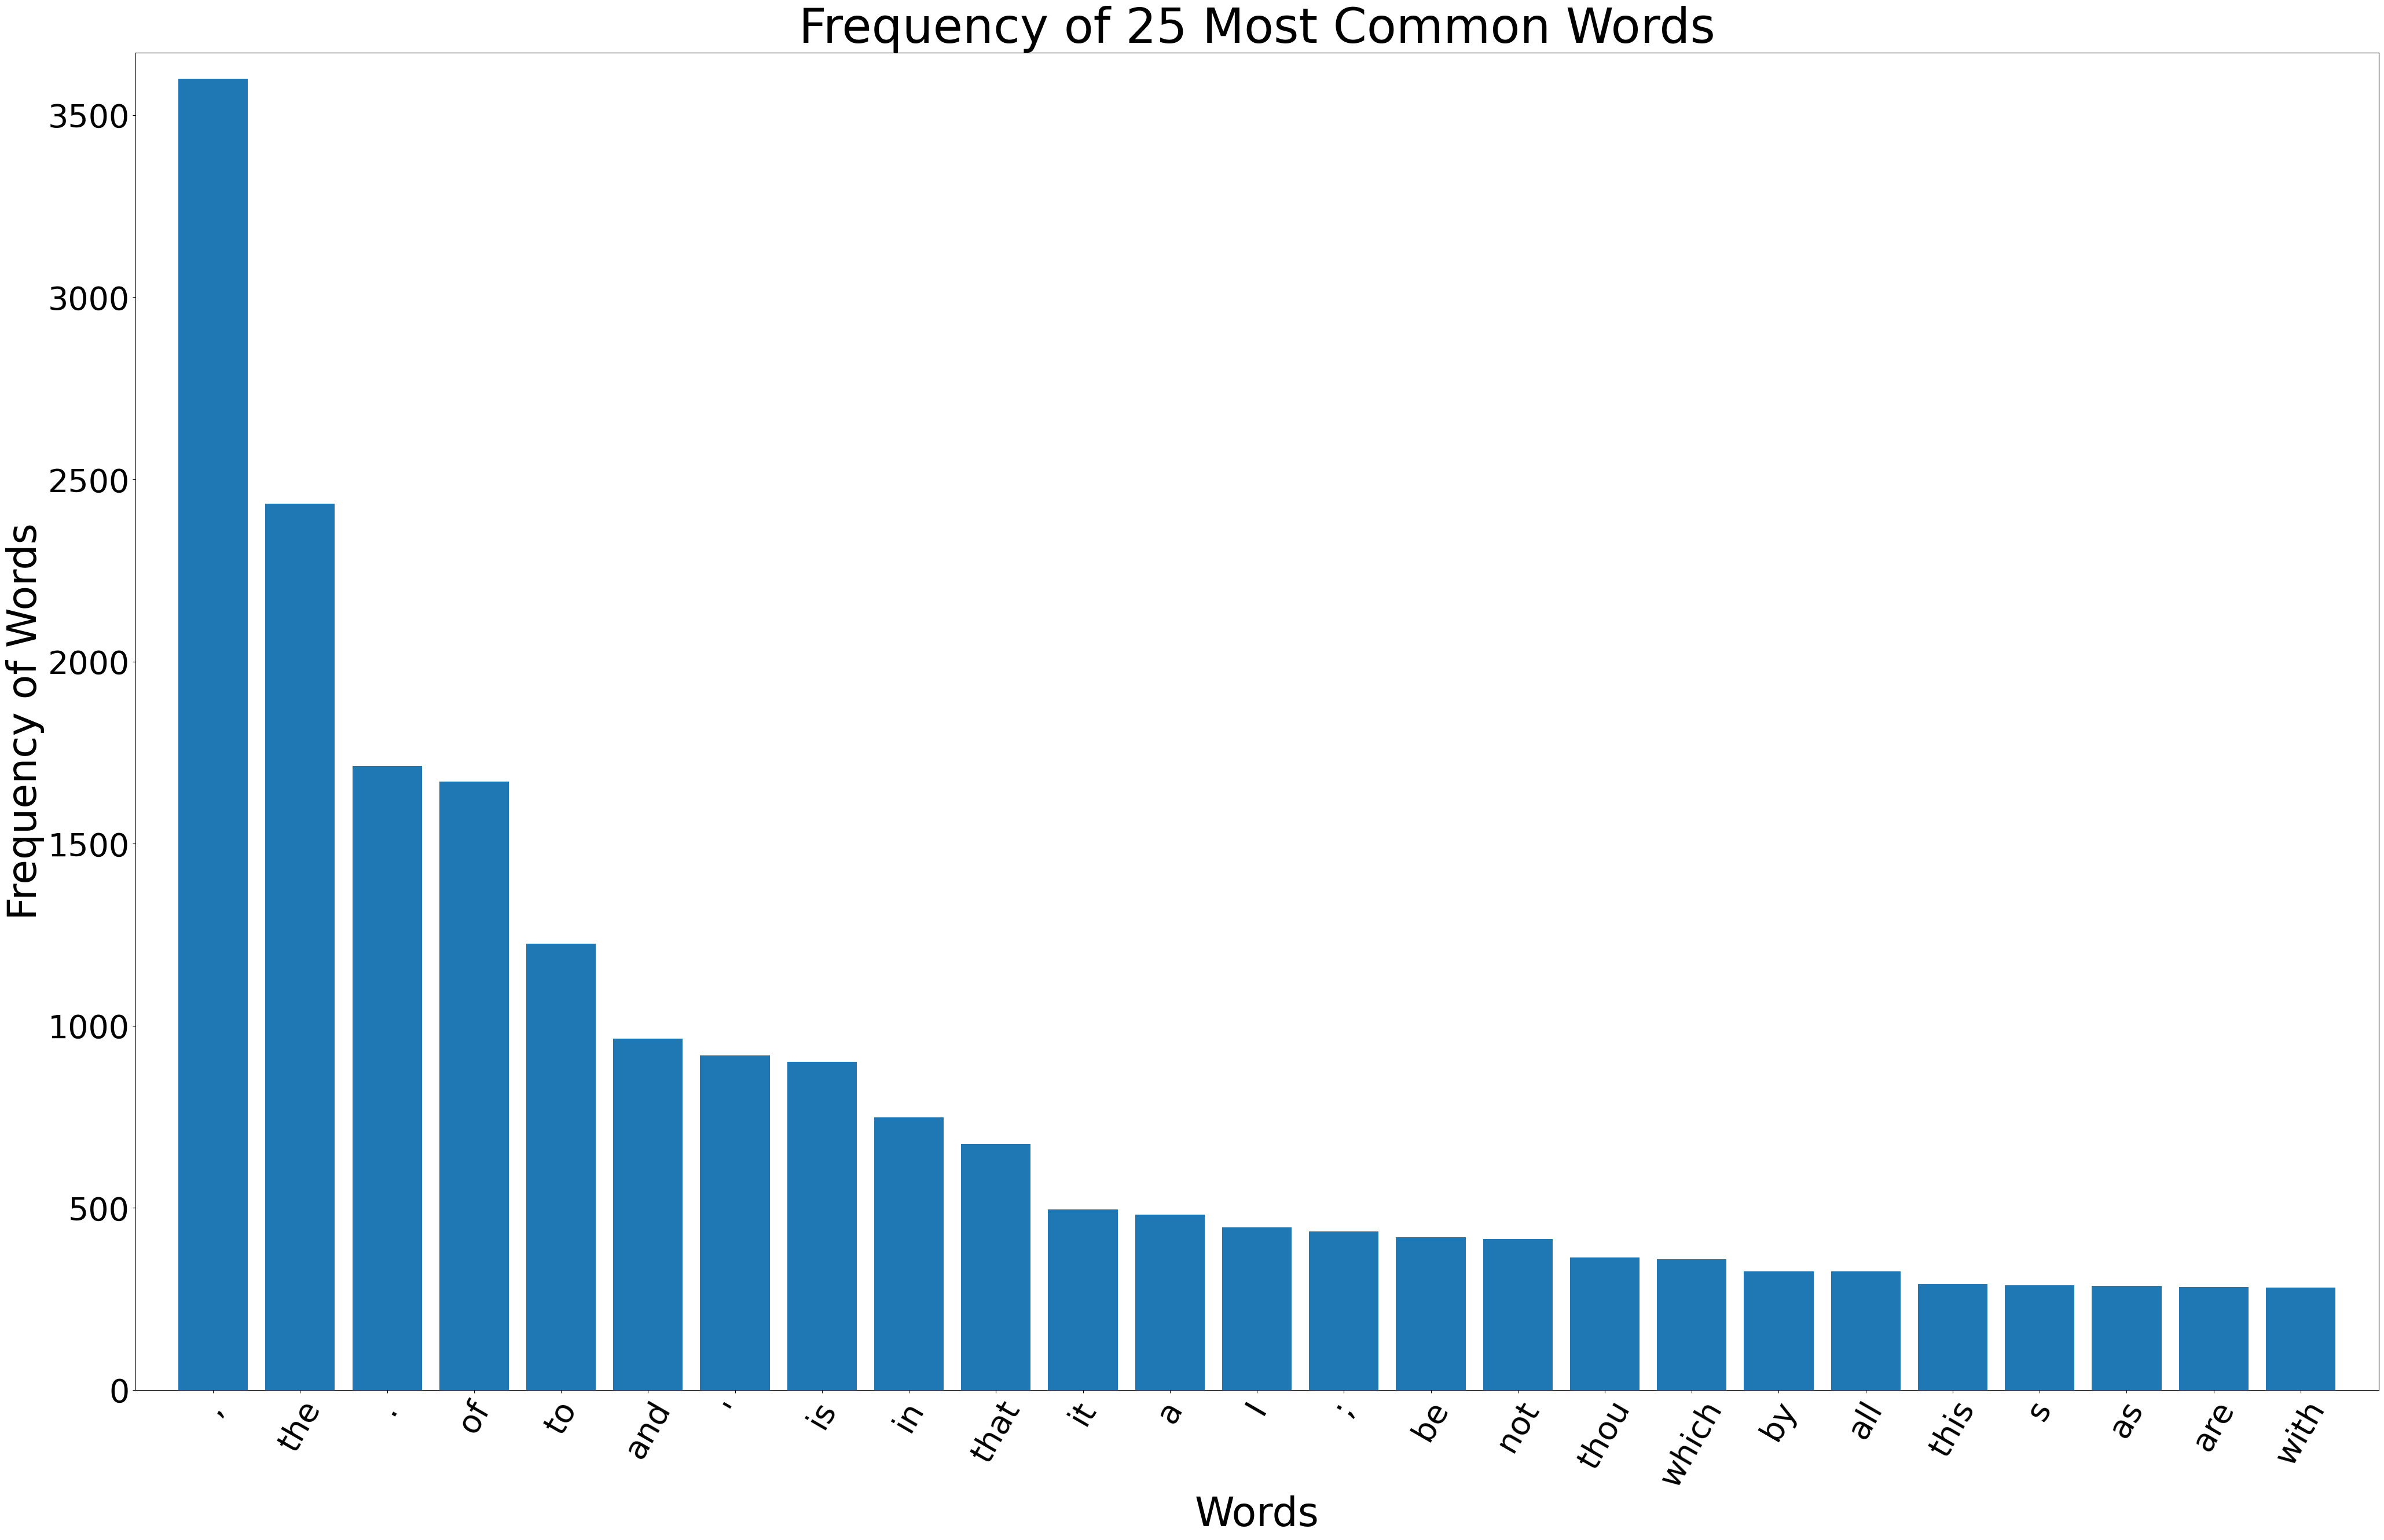

In [16]:
fdist_doc = nltk.FreqDist(docs[5]).most_common(25)

x, y = zip(*fdist_doc)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

## EDA at Sentence Level 

In [17]:
# Define the directory where the books are located
books_directory = "./text"

# Create a list to store the text data of each book
book_texts = []

# Loop through each file in the directory
for filename in os.listdir(books_directory):
    if filename.endswith('.txt'):
        with open(os.path.join(books_directory, filename), "r", encoding="utf8", errors='ignore') as file:
            book_text = file.read()
            book_texts.append(book_text)

In [18]:
# print(book_texts[0])

In [19]:
# Split the text into sentences using the nltk sentence tokenizer
book_sentences = list()
for book in book_texts:
    sentences = nltk.sent_tokenize(book)
    print(len(sentences))
    # print(sentences[:3])
    book_sentences.append(sentences)
print(book_sentences[0][:5])

867
1067
3630
3447
9005
21666
793
4610
3395
5935
21113
3279
12089
6093
1744
2260
9567
5884
818
5950
2186
1326
2107
1555
4834
2075
12021
9560
1752
2464
1001
3572
780
2735
8957
628
3123
4868
899
2242
5883
1766
1763
8415
3252
2161
2231
2004
2535
6052
674
4818
1717
1580
2511
20422
['*****The Project Gutenberg Etext of Utopia, by Thomas More*****\n#2 in our series by Thomas More\n\n\nCopyright laws are changing all over the world, be sure to check\nthe copyright laws for your country before posting these files!!', 'Please take a look at the important information in this header.', 'We encourage you to keep this file on your own disk, keeping an\nelectronic path open for the next readers.', 'Do not remove this.', '**Welcome To The World of Free Plain Vanilla Electronic Texts**\n\n**Etexts Readable By Both Humans and By Computers, Since 1971**\n\n*These Etexts Prepared By Hundreds of Volunteers and Donations*\n\nInformation on contacting Project Gutenberg to get Etexts, and\nfurther informatio

In [20]:
# Initialize variables to store the average sentence length, minimum and maximum sentence lengths
average_sentence_length = 0
min_sentence_length = float("inf")
max_sentence_length = float("-inf")
min_sen = ""
max_sen = ""

# Loop through each sentence
for sentence in book_sentences[5]:
    # Tokenize the sentence into words
    words = nltk.word_tokenize(sentence)
    # Calculate the length of the sentence
    sentence_length = len(words)
    # Update the average sentence length
    average_sentence_length += sentence_length
    # Update the minimum sentence length if necessary
    # min_sentence_length = min(min_sentence_length, sentence_length)
    if sentence_length < min_sentence_length:
        min_sentence_length = sentence_length
        min_sen = sentence
    # Update the maximum sentence length if necessary
    #max_sentence_length = max(max_sentence_length, sentence_length)
    if sentence_length > max_sentence_length:
        max_sentence_length = sentence_length
        max_sen = sentence


# Calculate the average sentence length
average_sentence_length = average_sentence_length / len(book_sentences[5])

# Print the results
print("Average sentence length:", average_sentence_length)
print("Minimum sentence length:", min_sentence_length)
print(min_sen)
print("Maximum sentence length:", max_sentence_length)
print(max_sen)

Average sentence length: 19.80988645804486
Minimum sentence length: 1
.
Maximum sentence length: 231
It seemed to him that in a normal development of
wealth in a state all these phenomena would arise only when a
considerable amount of labor had been put into agriculture, when
it had come under regular, or at least definite, conditions; that
the wealth of a country ought to increase proportionally, and
especially in such a way that other sources of wealth should not
outstrip agriculture; that in harmony with a certain stage of
agriculture there should be means of communication corresponding
to it, and that in our unsettled condition of the land, railways,
called into being by political and not by economic needs, were
premature, and instead of promoting agriculture, as was expected
of them, they were competing with agriculture and promoting the
development of manufactures and credit, and so arresting its
progress; and that just as the one-sided and premature
development of one organ in a

In [21]:
# POS + lemming for better lemming performance:
# The lemmatizer requires the correct POS tag to be accurate, 
# if you use the default settings of the WordNetLemmatizer.lemmatize(), the default tag is noun
# https://github.com/nltk/nltk/blob/develop/nltk/stem/wordnet.py#L39 
wnl = WordNetLemmatizer()

doc_lemmed = list()
for book in book_sentences:
    book_lemmed = list()
    for sen in book:
        sens = list()
        for word, tag in pos_tag(word_tokenize(sen)):
            wntag = tag[0].lower()
            wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
            lemma = wnl.lemmatize(word, wntag) if wntag else word
            sens.append(lemma)
        book_lemmed.append(sens)
    doc_lemmed.append(book_lemmed)

print(len(doc_lemmed))

56


In [26]:
print(doc_lemmed[5][:10])

[['*', '*', 'The', 'Project', 'Gutenberg', 'Etext', 'of', 'Anna', 'Karenina', ',', 'by', 'Leo', 'Tolstoy', '*', '*', '#', '5', 'in', 'our', 'series', 'by', 'or', 'about', 'Leo', 'Tolstoy', 'This', 'file', 'be', 'originally', 'release', 'as', 'nkrnna10', 'but', 'it', 'nkrnna09', 'My', 'apology', '.'], ['.'], ['.please', 'see', 'nkrnna10', '.', '*', '.'], ['.'], ['.'], ['.Michael', 'S.', 'Hart', 'Copyright', 'law', 'be', 'change', 'all', 'over', 'the', 'world', ',', 'be', 'sure', 'to', 'check', 'the', 'copyright', 'law', 'for', 'your', 'country', 'before', 'post', 'these', 'file', '!', '!'], ['Please', 'take', 'a', 'look', 'at', 'the', 'important', 'information', 'in', 'this', 'header', '.'], ['We', 'encourage', 'you', 'to', 'keep', 'this', 'file', 'on', 'your', 'own', 'disk', ',', 'keep', 'an', 'electronic', 'path', 'open', 'for', 'the', 'next', 'reader', '.'], ['Do', 'not', 'remove', 'this', '.'], ['*', '*', 'Welcome', 'To', 'The', 'World', 'of', 'Free', 'Plain', 'Vanilla', 'Electronic

In [23]:
# data normalisation
stop_list = stopwords.words('english')

doc_cleaned = list()

for book in doc_lemmed:
    #Lowercase
    sen = [[w.lower() for w in s] for s in book]
    # remove punctuations
    sentence = [[w for w in s if re.search('^[a-z]+$',w)] for s in book]
    # remove stop words
    sen = [[w for w in s if w not in stop_list] for s in book]
    # remove words with length < 3
    sentence1 = [[w for w in s if len(w)>3] for s in book]
    # remove empty lists
    if len(sentence1) > 0:
        doc_cleaned.append(sentence1)

In [24]:
print(len(doc_cleaned))
print(doc_cleaned[5][:20])

56
[['Project', 'Gutenberg', 'Etext', 'Anna', 'Karenina', 'Tolstoy', 'series', 'about', 'Tolstoy', 'This', 'file', 'originally', 'release', 'nkrnna10', 'nkrnna09', 'apology'], [], ['.please', 'nkrnna10'], [], [], ['.Michael', 'Hart', 'Copyright', 'change', 'over', 'world', 'sure', 'check', 'copyright', 'your', 'country', 'before', 'post', 'these', 'file'], ['Please', 'take', 'look', 'important', 'information', 'this', 'header'], ['encourage', 'keep', 'this', 'file', 'your', 'disk', 'keep', 'electronic', 'path', 'open', 'next', 'reader'], ['remove', 'this'], ['Welcome', 'World', 'Free', 'Plain', 'Vanilla', 'Electronic', 'Texts', 'Etexts', 'Readable', 'Both', 'Humans', 'Computers', 'Since', '1971', 'These', 'Etexts', 'Prepared', 'Hundreds', 'Volunteers', 'Donations', 'Information', 'contact', 'Project', 'Gutenberg', 'Etexts', 'further', 'information', 'include', 'below'], ['need', 'your', 'donation'], ['Project', 'Gutenberg', 'surf', 'with', 'modem', 'donate', 'Supra'], ['Anna', 'Karenin

## Topic Modelling

In [49]:
# vectorise the words
doc_dict = corpora.Dictionary([docs_stem[0]])
token_to_id = doc_dict.token2id
print(type(token_to_id))
# print(token_to_id) ？

# Converting all documents in SGNews Apr2012 to a list of sparse vectors.
docs_vecs = [doc_dict.doc2bow([doc]) for doc in docs_stem[0]]

print(docs_vecs[-1][-1])

# Train an LDA model on the corpus with 10 topics
lda_model = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=20, passes=20)

# Print the top 10 words in each of the 10 topics
for topic in lda_model.print_topics(num_topics=20, num_words=20):
    print(topic)

# compare similarity (not done)
# sample_index = similarities.SparseMatrixSimilarity(docs_vecs, 5471)

<class 'dict'>
(548, 1)
(0, '0.096*"know" + 0.094*"noth" + 0.046*"live" + 0.045*"chang" + 0.040*"doth" + 0.030*"aim" + 0.028*"word" + 0.021*"fame" + 0.020*"chain" + 0.019*"stand" + 0.016*"admit" + 0.014*"often" + 0.014*"fire" + 0.013*"among" + 0.013*"unjust" + 0.012*"nearli" + 0.011*"esteem" + 0.011*"shouldst" + 0.010*"ear" + 0.010*"whenev"')
(1, '0.132*"man" + 0.080*"agre" + 0.062*"thought" + 0.043*"day" + 0.039*"great" + 0.038*"fate" + 0.029*"last" + 0.029*"two" + 0.028*"prove" + 0.021*"ground" + 0.019*"prize" + 0.016*"ti" + 0.016*"error" + 0.016*"lack" + 0.013*"paradox" + 0.011*"bent" + 0.009*"lay" + 0.009*"favour" + 0.008*"enough" + 0.008*"cast"')
(2, '0.271*"thing" + 0.099*"may" + 0.072*"true" + 0.071*"would" + 0.052*"make" + 0.027*"plato" + 0.024*"everi" + 0.021*"gener" + 0.016*"brought" + 0.013*"contain" + 0.012*"manifest" + 0.012*"refer" + 0.008*"question" + 0.008*"born" + 0.007*"wind" + 0.007*"whatsoev" + 0.007*"cruel" + 0.007*"wisdom" + 0.006*"easili" + 0.006*"ask"')
(3, '0.1